Using device: cuda
Images in degraded test: 500
Number of Classes: 100
Detected checkpoint dictionary. Extracting 'model_state_dict'...
Model weights loaded successfully.
Starting inference on degraded test set...

Calculating metrics...

       FINAL AGGREGATED METRICS
Overall Accuracy:   0.8860 (88.60%)
----------------------------------------
MACRO AVERAGE (Unweighted mean per class):
  Precision: 0.8957
  Recall:    0.8860
  F1-Score:  0.8805
----------------------------------------
WEIGHTED AVERAGE (Weighted by class support):
  Precision: 0.8957
  Recall:    0.8860
  F1-Score:  0.8805

Detailed per-class metrics saved to: classification_report_full.csv

Generating Confusion Matrix plot...
Confusion Matrix saved as: confusion_matrix_baseline.png


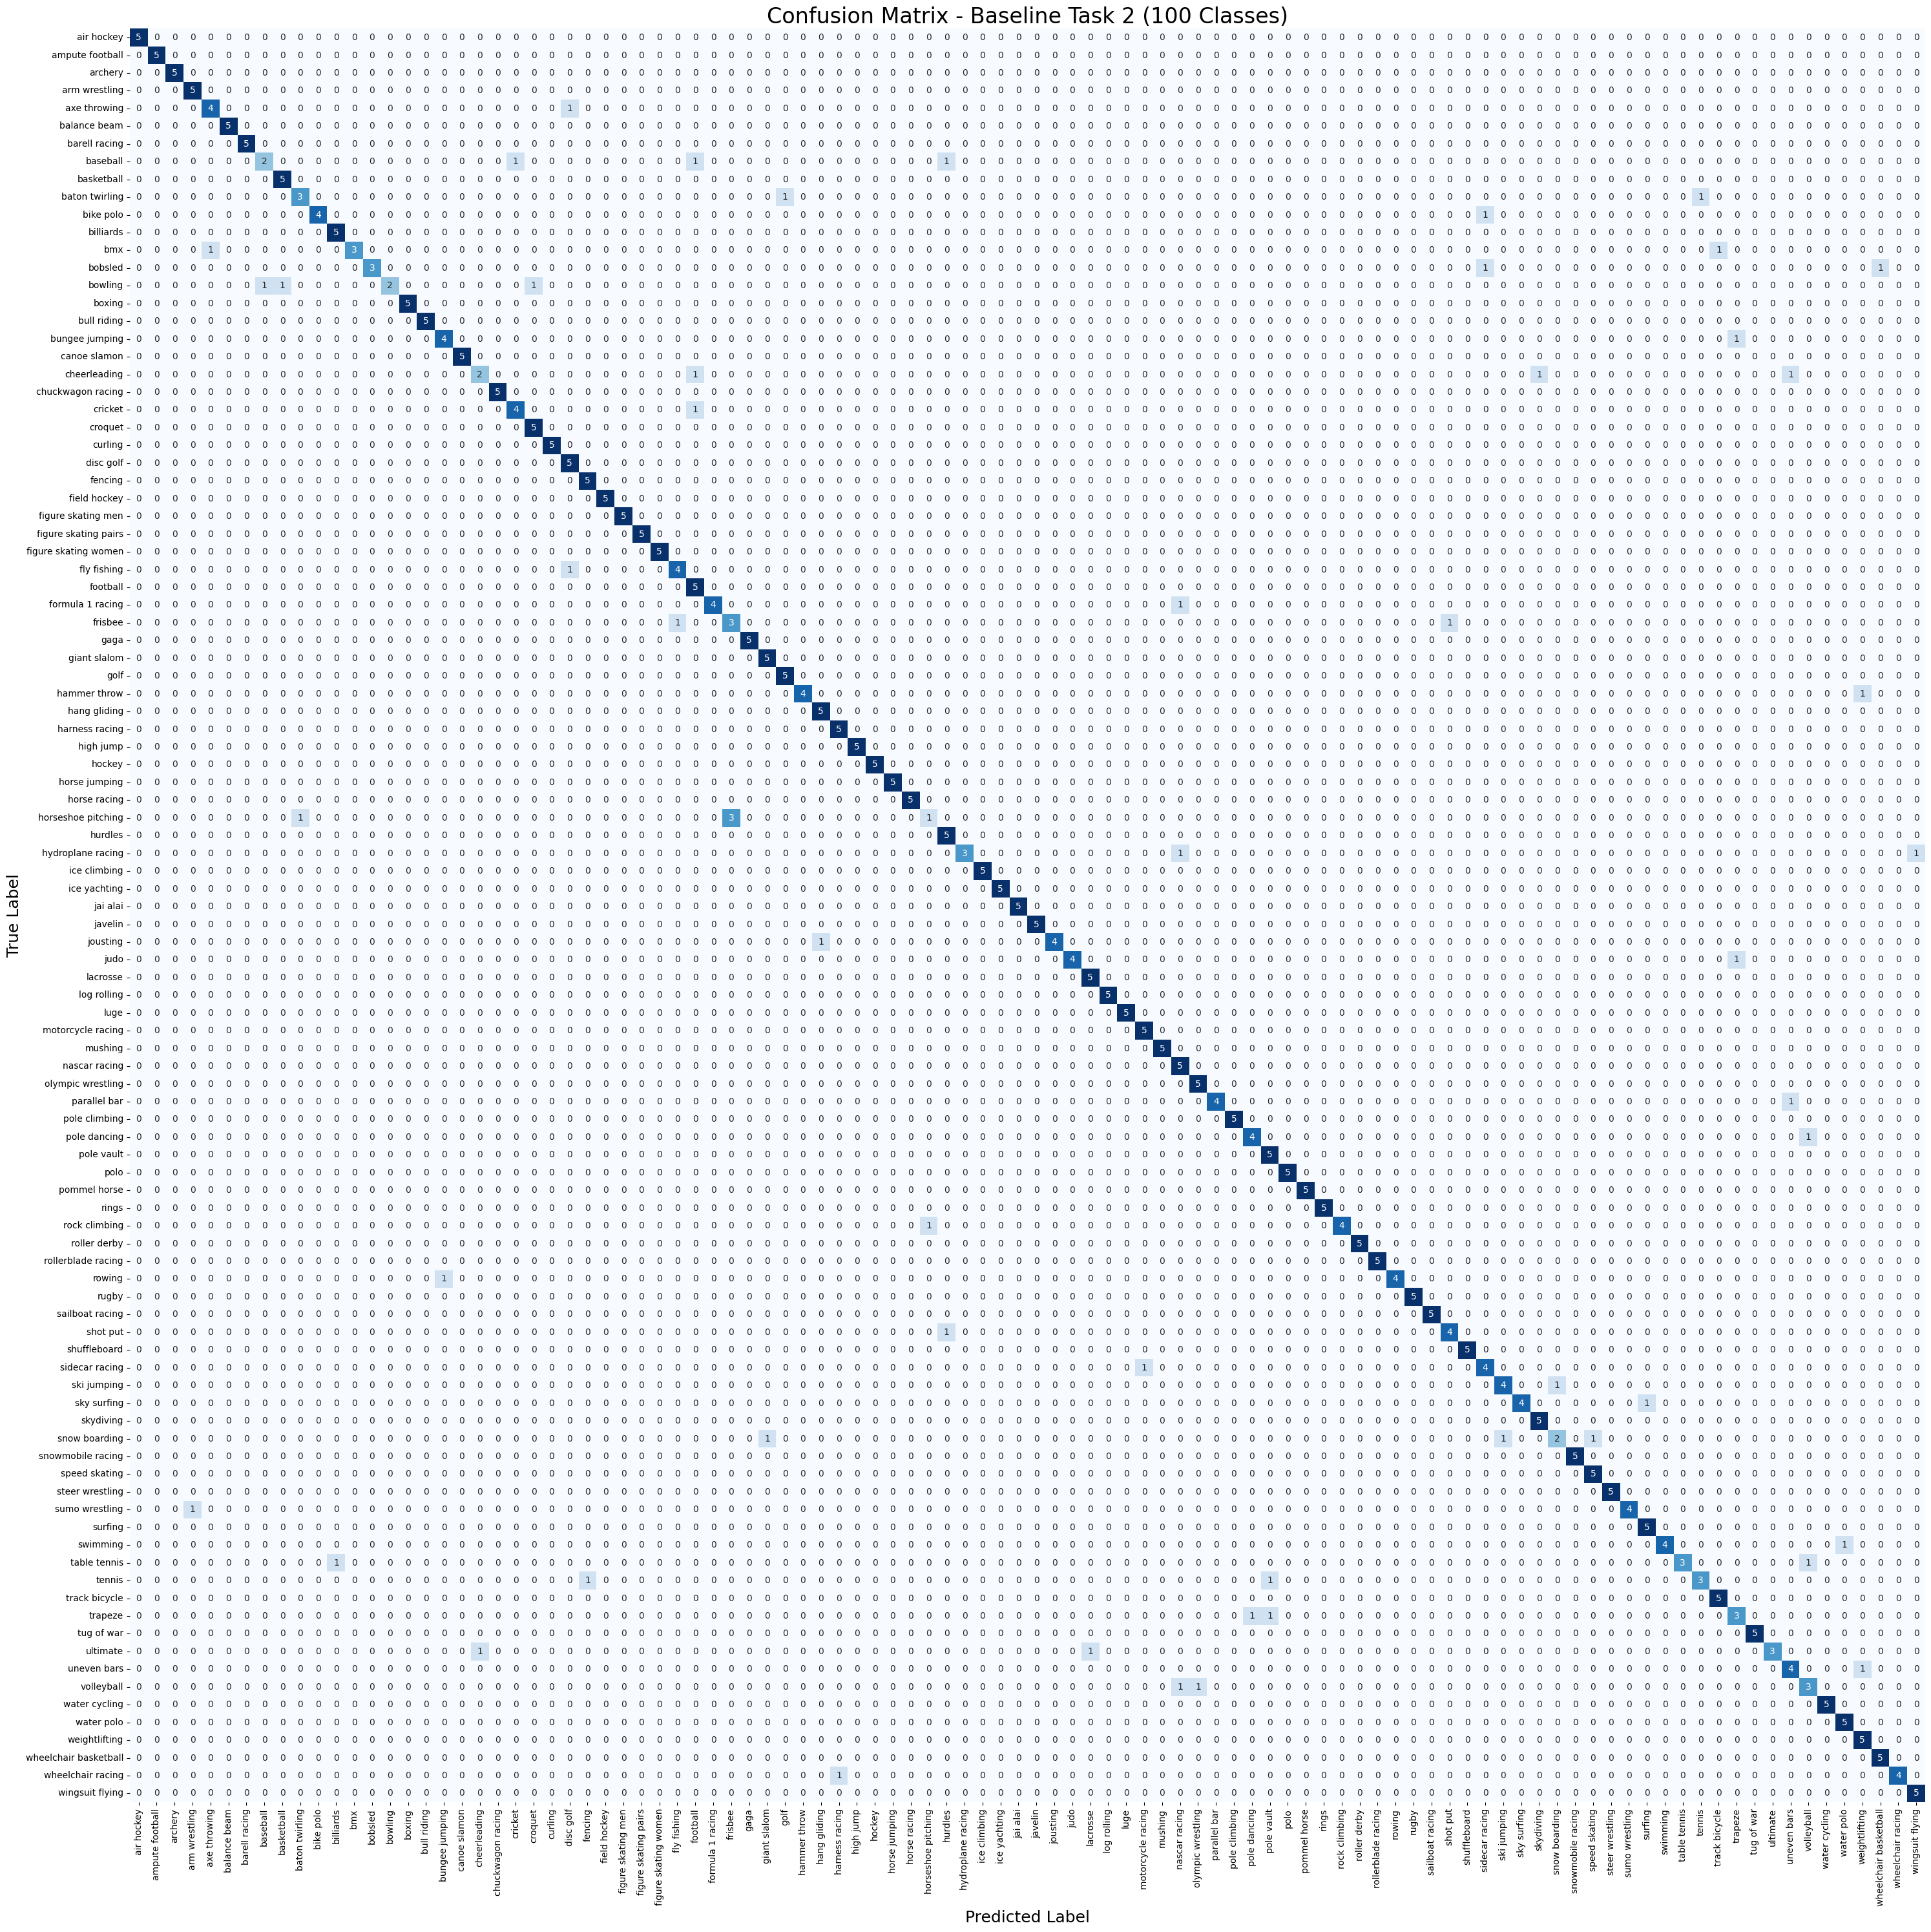

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Path to the 'test_degradato' folder
DEGRADED_TEST_DIR = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset-2/visual_dataset/test"
MODEL_PATH = "/kaggle/input/models/andreaspagnolo/task2-denoisetestset/pytorch/default/1/best_model_task2_denoiseTestSet.pth"
BATCH_SIZE = 64
NUM_CLASSES = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# ==========================================
# 2. MODEL DEFINITION
# ==========================================
def build_resnet18(num_classes: int) -> nn.Module:
    # We use weights=None because we are loading our custom weights
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ==========================================
# 3. TRANSFORMATIONS
# ==========================================
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

# ==========================================
# 4. PLOTTING FUNCTIONS
# ==========================================
def plot_confusion_matrix(cm, class_names, output_filename="confusion_matrix_baseline.png"):
    """
    Generates and saves a heatmap of the confusion matrix.
    """
    plt.figure(figsize=(30, 30))  # Large size for 100 classes
    sns.heatmap(
        cm, 
        annot=True,            # Write numbers in cells
        fmt='d',               # Integer format
        cmap='Blues',          # Blue colormap
        xticklabels=class_names, 
        yticklabels=class_names,
        cbar=False             # Remove colorbar to save side space
    )
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.title(f'Confusion Matrix - Baseline Task 2 ({len(class_names)} Classes)', fontsize=24)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=150)
    # plt.show() # Commented out for non-interactive environments
    print(f"Confusion Matrix saved as: {output_filename}")

# ==========================================
# 5. EVALUATION PIPELINE
# ==========================================
def run_baseline_with_full_metrics():
    if not os.path.exists(DEGRADED_TEST_DIR):
        print(f"[ERROR] Cannot find directory: {DEGRADED_TEST_DIR}")
        return

    # Dataset and DataLoader
    degraded_dataset = datasets.ImageFolder(DEGRADED_TEST_DIR, transform=test_transforms)
    degraded_loader = DataLoader(
        degraded_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    class_names = degraded_dataset.classes
    print(f"Images in degraded test: {len(degraded_dataset)}")
    print(f"Number of Classes: {len(class_names)}")

    # Load Model
    model = build_resnet18(NUM_CLASSES)
    
    try:
        # Load the file (which is a dictionary containing metadata + weights)
        checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
        
        # Check if it's a checkpoint dict or just weights
        if 'model_state_dict' in checkpoint:
            print("Detected checkpoint dictionary. Extracting 'model_state_dict'...")
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
            
        model.load_state_dict(state_dict)
        print("Model weights loaded successfully.")
    except Exception as e:
        print(f"[ERROR] Unable to load weights: {e}")
        return

    model.to(DEVICE)
    model.eval()

    # Lists to save predictions and targets
    all_preds = []
    all_targets = []

    print("Starting inference on degraded test set...")
    
    with torch.no_grad():
        for inputs, labels in degraded_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # --- METRICS CALCULATION ---
    
    print("\nCalculating metrics...")

    # 1. Generate Classification Report as a Dictionary
    report_dict = classification_report(
        all_targets, 
        all_preds, 
        target_names=class_names, 
        output_dict=True,
        zero_division=0
    )
    
    # 2. Extract Overall Averages
    accuracy = report_dict['accuracy']
    
    macro_avg = report_dict['macro avg']
    macro_precision = macro_avg['precision']
    macro_recall = macro_avg['recall']
    macro_f1 = macro_avg['f1-score']
    
    weighted_avg = report_dict['weighted avg']
    weighted_precision = weighted_avg['precision']
    weighted_recall = weighted_avg['recall']
    weighted_f1 = weighted_avg['f1-score']

    # --- PRINT RESULTS ---
    print("\n" + "="*40)
    print("       FINAL AGGREGATED METRICS")
    print("="*40)
    print(f"Overall Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("-" * 40)
    print("MACRO AVERAGE (Unweighted mean per class):")
    print(f"  Precision: {macro_precision:.4f}")
    print(f"  Recall:    {macro_recall:.4f}")
    print(f"  F1-Score:  {macro_f1:.4f}")
    print("-" * 40)
    print("WEIGHTED AVERAGE (Weighted by class support):")
    print(f"  Precision: {weighted_precision:.4f}")
    print(f"  Recall:    {weighted_recall:.4f}")
    print(f"  F1-Score:  {weighted_f1:.4f}")
    print("="*40)

    # 3. Save Detailed Metrics to CSV
    df_report = pd.DataFrame(report_dict).transpose()
    csv_filename = "classification_report_full.csv"
    df_report.to_csv(csv_filename)
    print(f"\nDetailed per-class metrics saved to: {csv_filename}")
    
    # 4. Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    print("\nGenerating Confusion Matrix plot...")
    plot_confusion_matrix(cm, class_names)

# Run
if __name__ == "__main__":
    run_baseline_with_full_metrics()